## Baseline Models for Age and Gender Prediction from MEG

In [1]:
%matplotlib inline

In [21]:
import sys
sys.path += ['../']
import matplotlib.pyplot as plt
from src.data.preprocess import run_pca
from src.data.make_dataset import load_dataset, load_subjects
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import hcp
import mne
import numpy as np
import pandas as pd

## Introduction

This notebook provides an example of building a predictive model for the age and gender 
classification tasks from preprocessed MEG data. To run the examples you will need the
preprocessed data downloaded from [link]() copied to the data folder in this repository. 

## MEG Data

MEG data consists of around 250 channels of continuous signal data representing the output of the 
sensors placed around the head in the MEG.  Each channel picks up electrical activity at a position on
the surface of the head.  Using advanced signal processing techniques we can localise some of this
activity and identify where in the brain responses to certain stimuli or actios occur.  

In these experiments we will be using __resting state recordings__ so no movement or events are
involved.  The subject is just sitting and thinking and we expect a relatively __steady state signal__.

## Segmentation

Our main dataset consists of around 95 subjects in three age categories (22-25, 26-30, 31-35).  The distribution
is unbalanced so we have selected 16 subjects from each category for the training data.  Each subject has three
recordings in the resting state and each is around 6 minutes long.  

Making the assumption that these recordings represent a steady state, we have cut them up into 20s segments
to create the target data for these experiments. Hence, our goal here is to build a model that can predict
age or gender from a 20s segment of resting state MEG data.  

## Preprocessing

There are a number of ways that we could generate features from these data segments. Recall that each
segment consists of around 250 individual signals.  Assuming that these are steady state we have 
used an __averaged FFT spectrum__ for each channel.   This gives us a 24 point FFT for each channel
in the data.   We have pre-computed these features for each segment and they are available in the downloaded preprocessed data directories.  

## Analysis

The first step is to load the dataset.  The file [hcp-train.csv](../data/hcp-train.csv) contains one
row per subject along with their gender and age category labels.  Note, if you want to look at all
of the subjects, [hcp-subjects.csv](../data/hcp-subjects.csv) contains all of their details.  

We will then create feature vectors from the raw array data.  We do this here by selecting the first
ten channels and concatenating them to give a 240 element feature vector for each recording.

In [3]:
def transform_data(data, channels):
    """Select a number of channels from each data record and concatenate them into a single vector"""
    
    return [np.ravel(d[0][:channels]) for d in data['data']]    

In [4]:
dataset = load_dataset('../data/processed/hcp', '../data/hcp-train.csv')
channels = 10
dd = transform_data(dataset, channels)

## Visualisation

We can define a simple visualisation of the data to get an idea of what we are working with. 

In [5]:
def show(n):
    data = dd[n]
    data = data.reshape(channels,24)
    plt.pcolor(data)
    print(dataset['age'][n], dataset['gender'][n])

22-25 F


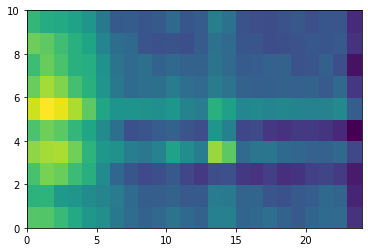

In [6]:
show(0)

26-30 F


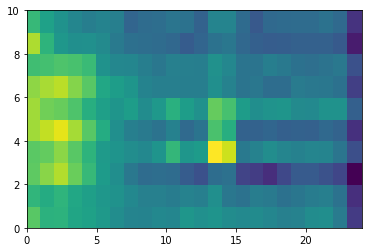

In [7]:
show(1000)

31-35 F


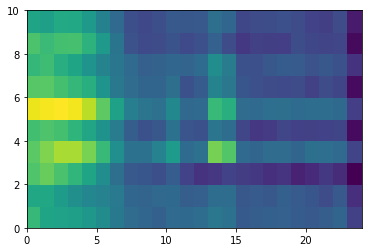

In [8]:
show(2001)

## Baseline Model

For a baseline we define a simple support vector machine model and train on this dataset.

In [40]:
age_model = svm.SVC(gamma=0.01, C=10.)
age_model.fit(dd, dataset['age'])

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
def evaluate(model, key, data, ref):
    predicted = model.predict(data)
    print("{:.2f}% correct".format(100*accuracy_score(ref[key], predicted)))
    print(confusion_matrix(ref[key], predicted))

In [42]:
evaluate(age_model, 'age', dd, dataset)

99.96% correct
[[815   0   0]
 [  0 822   0]
 [  0   1 867]]


## Predicting Gender

We can repeat the process to predict gender using a similar model. 

In [43]:
gender_model = svm.SVC(gamma=0.01, C=10.)
gender_model.fit(dd, dataset['gender'])


SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
evaluate(gender_model, 'gender', dd, dataset)

100.00% correct
[[ 931    0]
 [   0 1574]]


## Evaluation

For evaluation we have withheld 11 subjects. Their identifiers are in [hcp-eval-dist.csv](../data/hcp-eval-dist.csv).  To evaluate our model, we load these subjects in the same way as the original data.  To evaluate the model we will generate the predicted age category labels for each entry and write them to a CSV file. 

In [45]:
testdataset = load_dataset('../data/processed/hcp', '../data/hcp-eval-dist.csv')
channels = 10
td = transform_data(testdataset, channels)

age = age_model.predict(td)
gender = gender_model.predict(td)

In [46]:
predicted_df = pd.DataFrame({'id': testdataset['id'], 'age': age, 'gender': gender})
predicted_df.head()

,id,age,gender
0,391631-15-1,31-35,F
1,391631-15-0,31-35,F
2,391631-17-2,26-30,F
3,391631-17-0,31-35,F
4,391631-15-2,31-35,F


## Generating your own Features

We've written code to process the MEG data using the [MNE](https://mne.tools/) package.  You can 
use this as the basis of your own preprocessinng if you want to use different features. 

In [ ]:
def read_hcp(subject: str, data_folder: str, run_index: int) -> mne.io.Raw:
    """
    Read a data file from the HCP dataset, return a Raw instance
    """

    raw = hcp.read_raw(subject=subject, data_type='rest', hcp_path=data_folder, run_index=run_index)

    return raw

In [47]:

def spectral_epochs(label: str, raw: mne.io.Raw, epoch_size: int, max_freq: int = 100, n_fft: int = 48) -> np.array: 
    """Read raw data and split into epochs of a given size (s), compute features
    over each one
    label: subject identifier
    epoch_size: duration of epochs in seconds
    data_folder: location of source data
    max_freq: max frequency for FFT (default 100)
    n_fft: FFT size (default 48)

    Returns: labels, features
    labels: a list of labels with the format <subject>-<run_index>-<N>
    features: a list of np.arrays one per epoch containing the features
    """

    features = []
    labels = []

    events = mne.make_fixed_length_events(raw, id=1, duration=epoch_size)
    epochs = mne.Epochs(raw, events, tmin=0., tmax=epoch_size, baseline=None,
                        detrend=1, decim=8, preload=True)

    for N in range(len(epochs)):
        features.append(spectral_features(epochs[N], max_freq=max_freq, n_fft=n_fft))
        labels.append("{}-{}".format(label, N))
        print('.', end='', flush=True)
    print('|', end='', flush=True)        
    return labels, features

In [ ]:
def spectral_features(raw: mne.io.Raw, max_freq: int = 100, n_fft: int = 48) -> np.array: 
    """Compute flattened spectral features given a cropped raw recording.

    Data is low-pass filtered to max_freq (default 100Hz) and downsampled to 2*max_freq before features are
    computed. 

    Computes a n_fft (default 48) point FFT. Takes the log to compute the final features which
    are then concatenated into a one dimensional feature vector.

    Returns a N x 24 np.array where N is the number of channels"""

    raw.filter(None, max_freq, h_trans_bandwidth=0.5, filter_length='10s', phase='zero-double', fir_design='firwin2')
    raw.resample(2*max_freq, npad="auto")

    psds, _freqs = mne.time_frequency.psd_welch(raw, fmin=1, n_fft=n_fft)

    return np.log(psds)